# **MÉTODO 3**
# **Contrafactuales guiados por prototipos (CFP)**

Este método se describe en el artículo https://arxiv.org/abs/1907.02584 y puede generar instancias contrafactuales guiadas por prototipos de clase.

Para una determinada instancia X, el método crea un prototipo para cada clase de predicción utilizando un ***codificador automático***(tipo de red neuronal artificial que se utiliza para aprender codificaciones eficientes de datos sin etiquetar, aprendizaje no supervisado) o ***árboles k-dimensionales***. Luego, se utiliza la clase prototipo más cercana distinta de la clase predicha originalmente para guiar la búsqueda contrafactual.


##### *Ejemplo dataset MNIST*
*Con el `dataset MNIST` la clase más cercana a un 7 podría ser un 9. Como resultado, el término de pérdida del prototipo intentará minimizar la distancia entre el contrafactual propuesto y el prototipo de un 9. Esto acelera la búsqueda hacia un contrafactual satisfactorio. dirigiéndolo hacia una solución interpretable desde el inicio de la optimización. También ayuda a evitar contrafactuales fuera de distribución con las perturbaciones dirigidas a un prototipo de otra clase.*


La **función de pérdida** a optimizar es la siguiente:

$$
Loss = c \cdot L_{pred} + \beta \cdot L_1 + L_2 + L_{AE} + L_{proto}
$$

El primer término de pérdida se relaciona con la función de predicción del modelo, los siguientes 2 términos definen la regularización neta elástica mientras que los 2 últimos términos son opcionales. El objetivo de $L_{AE}$
es penalizar los contrafactuales fuera de distribución mientras $L_{proto}$
guía el contrafactual hacia un prototipo.

Cuando solo tenemos acceso a la función de predicción del modelo y no podemos disfrutar plenamente de los beneficios de la diferenciación automática, los prototipos nos permiten eliminar el término de pérdida de la función de predicción $L_{pred}$ y seguir generando contrafactuales de alta calidad. Esto reduce drásticamente la cantidad de llamadas de predicción realizadas durante el paso de actualización del gradiente numérico y nuevamente acelera la búsqueda.

Este método produce resultados mucho más interpretables que CFI() y CEM().

Debido a que el término prototipo dirige la solución, podemos eliminar el término de pérdida de predicción. Esto hace que este método sea mucho más rápido si utilizamos un modelo de caja negra, ya que no necesitamos calcular los gradientes numéricamente. Sin embargo, en ocasiones el prototipo no es miembro de la clase objetivo. En este caso, terminará con un contrafactual incorrecto.

Otras opciones incluyen generar contrafactuales para clases específicas o incluir restricciones de puntuación de confianza para garantizar que el contrafactual sea lo suficientemente cercano a la clase recién predicha en comparación con la clase original. A lo largo de este cuaderno se ilustran diferentes casos de uso.

## EJEMPLOS DE USO

Para habilitar la compatibilidad con `CounterfactualProto`, es posible que debamos ejecutar previamente el siguiente código en la consola:

    pip install alibi[tensorflow]

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import os
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from alibi.explainers import CounterfactualProto

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.14.1
Eager execution enabled:  False


En la `librería Alibi`:

-**1. Explicaciones contrafactuales con variables categóricas codificadas one-hot u ordinalmente**.

-**2. Contrafactuales guiados por prototipos en el conjunto de datos de vivienda de California**.

-**3. Contrafactuales guiados por prototipos en MNIST**.

## **1. Explicaciones contrafactuales con variables categóricas codificadas con one-hot encoding u ordinalmente**

Método para explicar modelos de aprendizaje automático que maneja datos con variables categóricas.

A diferencia de los métodos convencionales que pueden no capturar la estructura subyacente de los datos, este método utiliza el contexto proporcionado por otras características y/o las predicciones del modelo para capturar la relación entre categorías. Esto se logra mediante la captura de distancias entre categorías y su posterior escalamiento multidimensional.

Para más información sobre un ejemplo concreto de este ejemplo de uso:
https://docs.seldon.io/projects/alibi/en/latest/examples/cfproto_cat_adult_ohe.html

## **2. Contrafactuales guiados por prototipos en el conjunto de datos de vivienda de California**

A continuación, vamos a analizar un ejemplo de uso mediante árboles k-dimensionales para la construcción de los prototipos. Entrenaremos una red neuronal simple para predecir si los precios de la vivienda en los distritos de California están por encima del valor medio y luego, buscaremos un contrafactual para ver qué variables deben cambiarse para aumentar o disminuir el precio de una vivienda por encima o por debajo del valor medio.



### Carga y preparación del conjunto de datos de vivienda de California

Cargamos los datos desde el módulo sklearn.datasets, extraemos sus características y su objetivo, y obtenemos los nombres de cada una de las características.

In [5]:
california = fetch_california_housing(as_frame=True)
X = california.data.to_numpy()
target = california.target.to_numpy()
feature_names = california.feature_names

california.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Cada fila representa un grupo censal completo. Explicación de características:

-`MedInc`- ingreso medio en el grupo de bloques.

-`HouseAge`- edad media de la vivienda en el grupo de bloques.

-`AveRooms`- número medio de habitaciones por hogar.

-`AveBedrms`- número medio de dormitorios por hogar.

-`Population`- bloquear la población del grupo.

-`AveOccup`- número medio de miembros del hogar.

-`Latitude`- latitud del grupo de bloques.

-`Longitude`- longitud del grupo de bloques.

Lo vamos a transformar en una **tarea de clasificación**: 
el objetivo se convierte en saber si el precio de la vivienda está por encima de la mediana general o no.

Creamos un nuevo array de numpy `y`, lleno de ceros y con la misma longitud que `target`. Sobre `y`, reemplazamos por el valor 1 aquellos índices donde los valores en `target` son mayores que su mediana.

In [6]:
y = np.zeros((target.shape[0],))
y[np.where(target > np.median(target))[0]] = 1

Estandarizamos los datos

In [7]:
mu = X.mean(axis=0)
sigma = X.std(axis=0)
X = (X - mu) / sigma

Definimos los conjuntos de entrenamiento y de prueba(que representará el 20% de los datos). Luego, utilizamos la función `to_categorical` para convertir las etiquetas de los conjuntos de entrenamiento y de test en formato de codificacion one-hot encoding.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Definimos la función `nn_model` que define una red neuronal con dos capas densas de 40 neuronas cada una y una capa de salida con 2 neuronas(representando las dos clases de salida) con la función de activación `softmax`. La red se compilará usando la función de loss `categorical_crossentropy`, el optimizador `sgd` y la métrica de monotorización `accuracy`.

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
def nn_model():
    x_in = Input(shape=(8,))
    x = Dense(40, activation='relu')(x_in)
    x = Dense(40, activation='relu')(x)
    x_out = Dense(2, activation='softmax')(x)
    nn = Model(inputs=x_in, outputs=x_out)
    nn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return nn

Entrenamos el modelo con los datos de entrenamiento y lo guardamos en un archivo en formato HDF5.

In [11]:
nn = nn_model()
nn.summary()
nn.fit(X_train, y_train, batch_size=64, epochs=500, verbose=0)
nn.save('nn_california.h5', save_format='h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 40)                360       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 2)                 82        
                                                                 
Total params: 2082 (8.13 KB)
Trainable params: 2082 (8.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


c:\Users\inese\anaconda3\envs\NLP\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Observamos el accuracy del modelo:

In [12]:
nn = load_model('nn_california.h5')
score = nn.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

c:\Users\inese\anaconda3\envs\NLP\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy:  0.87451553


### Generación del contrafactual guiado por el prototipo de clase más cercano

Instancia original:

Remodelación del conjunto de prueba para que tenga una dimensión adicional al principio.

In [13]:
X = X_test[1].reshape((1,) + X_test[1].shape)
shape = X.shape

Carga del previo modelo e inicialización del objeto `CounterfactualProto`  para explicar las predicciones del modelo cargado usando árboles k-dimensionales, un parámetro de suavizado `theta`=10, un número máximo de iteraciones, el rango de características...

In [14]:
nn = load_model('nn_california.h5')

cf = CounterfactualProto(nn, shape, use_kdtree=True, theta=10., max_iterations=1000,
                         feature_range=(X_train.min(axis=0), X_train.max(axis=0)),
                         c_init=1., c_steps=10)

cf.fit(X_train)

c:\Users\inese\anaconda3\envs\NLP\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
No encoder specified. Using k-d trees to represent class prototypes.


CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 8),
              'kappa': 0.0,
              'beta': 0.1,
              'feature_range': (array([-1.77429947, -2.19618048, -1.83504572, -1.61076772, -1.25612255,
       -0.22899997, -1.44288613, -2.38599234]), array([  5.85828581,   1.85618152,  55.16323628,  51.78248741,
        30.25033022, 119.41910319,   2.95806762,   2.62528006])),
              'gamma': 0.0,
              'theta': 10.0,
              'cat_vars': None,
              'ohe': False,
              'use_kdtree': True,
              'learning_rate_init': 0.01,
              'max_iterations': 1000,
              'c_init': 1.0,
              'c_steps': 10,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'is_model': True,
              '

Generación de la explicación contrafactual para una instancia en particular X. La explicación resultante se almacena en la variable ***explanation***, que puede contener información sobre cómo cambiar las características de X para que la predicción del modelo cambie.

In [15]:
explanation = cf.explain(X)

Se visualiza la predicción original y la predicción contrafactual obtenidas como parte de la explicación contrafactual generada.

In [16]:
print(f'Original prediction: {explanation.orig_class}')
print(f'Counterfactual prediction: {explanation.cf["class"]}')

Original prediction: 0
Counterfactual prediction: 1


La predicción pasó de 0 (valor por debajo de la mediana) a 1 (por encima de la mediana):

Echemos un vistazo al contrafactual. Para que los resultados sean más interpretables, primero desharemos el paso de preprocesamiento y luego verificaremos en qué se diferencia el contrafactual de la instancia original:

In [18]:
orig = X * sigma + mu
counterfactual = explanation.cf['X'] * sigma + mu
delta = counterfactual - orig
for i, f in enumerate(feature_names):
    if np.abs(delta[0][i]) > 1e-4:
        print(f'{f}: {delta[0][i]}')

AveOccup: -0.724322499801721
Latitude: -0.27665028505489175


Entonces, para que el modelo considere que el grupo censal tiene precios de vivienda superiores a la mediana, la ocupación promedio(`AveOccup:`) tendría que ser menor en casi un miembro completo del hogar, y la ubicación del grupo censal(`Latitude`) tendría que desplazarse ligeramente hacia el sur.

Comparando el caso original y el contrafactual uno al lado del otro:

In [19]:
pd.DataFrame(orig, columns=feature_names)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46


In [20]:
pd.DataFrame(counterfactual, columns=feature_names)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.5313,30.0,5.039384,1.193493,1565.000004,1.955472,34.86335,-119.46


Limpiar:

In [21]:
os.remove('nn_california.h5')

## **3. Contrafactuales guiados por prototipos en MNIST**

### Cargar y preparar datos MNIST

El conjunto de datos MNIST contiene un conjunto de entrenamiento de 60.000 imágenes en escala de grises de 28x28 de 10 dígitos, junto con un conjunto de prueba de 10.000 imágenes.

Los dígitos representados varían entre el 0 y el 9, por lo que tendremos solamente representaciones de estos.

In [22]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_test shape: (10000, 28, 28) y_test shape: (10000,)


### Preparar datos: escalar, remodelar y categorizar

Realizamos la **normalización** de los valores de píxeles de las imágenes tanto en el conjunto de entrenamiento como en el de test, convirtiéndolos a tipo 'float32' y luego dividiendo cada valor por 255.

Realizamos una **reorganización** tanto del conjunto de entrenamiento como del de prueba para agregar una dimensión adicional al final, necesaria para trabajar con convoluciones dde Keras o TensorFlow.

Realizamos una **categorización de las etiquetas de clase** para los dos conjuntos a representaciones de one-hot encoding

In [23]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


Volvemos a normalizar los valores de píxeles de las imágenes en los conjuntos de entrenamiento y prueba para que estén dentro de un rango específico definido por $x_{min}=-0.5$ y $x_{max}=0.5$.

In [24]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

### Definir y entrenar el modelo CNN

Se define un modelo CNN(Convolutional Neural Network) para clasificar las imágenes MNIST.

Se utilizan capas convolucionales y de max-pooling seguidas de dropout para reducir el overfitting. Por lo que podemos intuir que las características se aplanan y se conectan a través de capas densas para la clasificación, con salida softmax y compilación con pérdida categórica y optimizador Adam.

In [25]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

Procedemos a entrenar el modelo utilizando x_train y las etiquetas correspondientes y_train. Se especifica un batch_size de 32, 3 épocas de entrenamiento y se omite la salida de progreso durante el entrenamiento (verbose=0).

Además, se guarda el modelo entrenado en un archivo llamado 'mnist_cnn.h5' en el formato de archivo HDF5 ('.h5'), lo que es muy beneficioso ya que este archivo puede ser utilizado más tarde para cargar el modelo y realizar predicciones sin necesidad de volver a entrenarlo.

In [26]:
cnn = cnn_model()
cnn.fit(x_train, y_train, batch_size=32, epochs=3, verbose=0)
cnn.save('mnist_cnn.h5', save_format='h5')

c:\Users\inese\anaconda3\envs\NLP\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluamos el modelo en el conjunto de prueba utilizando x_test y sus etiquetas correspondientes y_test. El resultado se almacena en la variable score.

In [27]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

c:\Users\inese\anaconda3\envs\NLP\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy:  0.9885


Obtenemos una precisión del 98.85%, lo que significa que generalmente se obtienen muy buenos resultados.

### Definir y entrenar el codificador automático

Se define una nueva función para el **autoencoder** o codificador automático que contiene las siguientes partes diferenciadas:

-**Encoder**: Tomamos imágenes de entrada de dimensiones (28x28x1) y consta de dos capas convolucionales seguidas de una capa de agrupación máxima(max-pooling) para extraer características y reducir la dimensionalidad.

-**Decoder**: A través de la representación codificada por el encoder, reconstruye la forma original de la imagen. Inicia con capas convolucionales y luego utiliza la operación de upsampling (interpolación) para aumentar la resolución de la imagen.

La función devolverá tres modelos: el autoencoder completo, el encoder y el decoder.

In [28]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

Entrenamos el sutoencoder con los datos de x_train, especificando un tamaño de lote de 128, 4 épocas de entrenamiento y utilizando los datos de x_test como datos de validación.

Guardamos tanto el modelo de autoencoder entrenado en un archivo llamado 'mnist_ae.h5' cmomo el modelo del codificador (enc) en un archivo llamado 'mnist_enc.h5'. Esto permitirá utilizar el codificador o encoder por separado si es necesario.

In [29]:
ae, enc, dec = ae_model()
ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
ae.save('mnist_ae.h5', save_format='h5')
enc.save('mnist_enc.h5', save_format='h5')

### Comparar imágenes originales con imágenes decodificadas

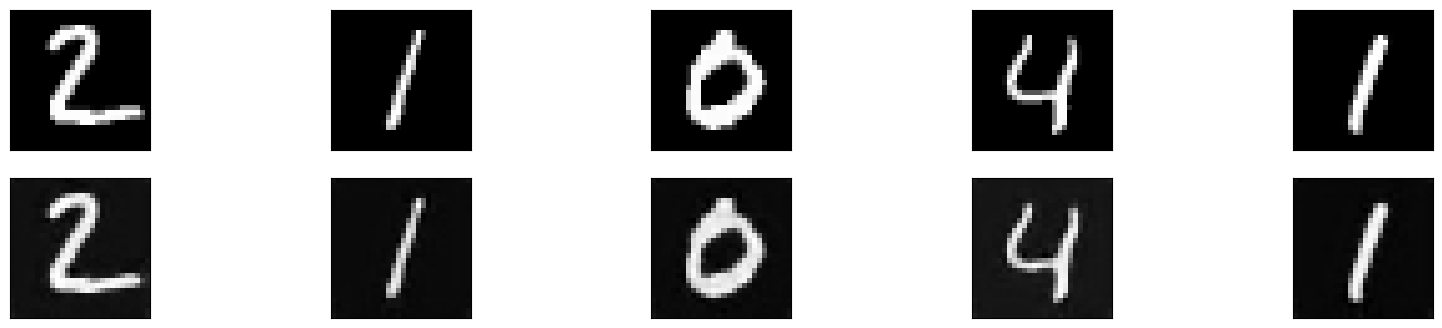

In [31]:
ae = load_model('mnist_ae.h5')
enc = load_model('mnist_enc.h5', compile=False)

decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Generar contrafactual guiado por el prototipo de clase más cercano

Procedemos a elegir una imágen concreta dentro de nuestro conjunto de datos de prueba, reformateandola para que tenga la forma de: (1,28,28,1). Además, la visualizamos para poder tener en cuenta las siguientes opearciones.


#### Instancia original:

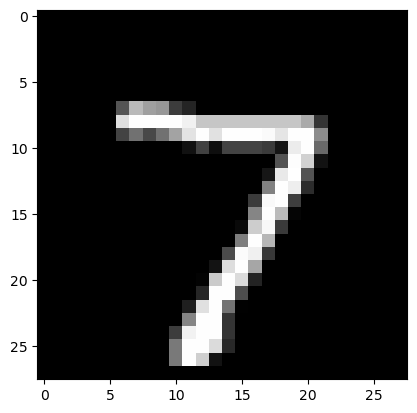

In [33]:
X = x_test[0].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28), cmap='gray');

Observamos que se trata, claramente, del dígito 7.

#### Parámetros contrafactuales:

A partir de las siguientes definiciones de los elementos, se pretende controlar la creación y la búsqueda de un contrafactual que sea cercano y relevante de un prototipo en específico, mientras se mantiene coherencia con los datos originales y las restricciones del problema.

Explicamos paso a paso cada una de las nuevas definiciones:

· `shape`: representa una dimensión adicional que se agrega a los datos originales para crear un prototipo de contrafactual.

· `gamma` y `theta`: son valores de ajuste específicos que controlan la magnitud y la dirección del cambio deseado en el contrafactual.

- `c_init`, `c_steps` y `max_iterations`: son el punto de partida inicial, el número de pasos y el límite máximo de iteraciones de la búsqueda, respectivamente.

- `feature_range`: rango permitido de valores para las características modificadas en el contrafactual.

In [34]:
shape = (1,) + x_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())

Ejecute contrafactual:

Proceddemos a inicializar un objeto de ***CounterfactualProto***, que es un explicador de contrafactuales guiado por prototipo. Se pasan como parámetros el `modelo de clasificación cnn`, la forma de los datos `shape`, así como otros parámetros como `gamma`, `theta`, `ae_model`, `enc_model`, `max_iterations`, `feature_range`, `c_init` y `c_steps`. Además, se ajusta el explicador a x_train para encontrar prototipos de clase y se genera una explicación para la instancia X dada, lo que implica generar un contrafactual que explique la predicción del modelo para X en términos de cambios en las características.

In [35]:
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
start_time = time()
cf.fit(x_train)  
print('Time to find prototypes each class: {:.3f} sec'.format(time() - start_time))
start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Time to find prototypes each class: 11.514 sec
Explanation took 3.733 sec


Resultados:

Counterfactual prediction: 9
Closest prototype class: 9


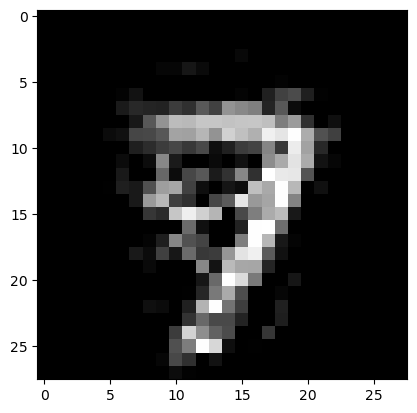

In [36]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28), cmap='gray');

El contrafactual que parte de un 7 avanza hacia su clase prototipo más cercana: un 9. La evolución del contrafactual durante la primera iteración se puede ver a continuación:

iteration c 0


C:\Users\inese\AppData\Local\Temp\ipykernel_17832\3470368917.py:3: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  n = len(explanation['all'][iter_cf])
C:\Users\inese\AppData\Local\Temp\ipykernel_17832\3470368917.py:7: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  plt.imshow(explanation['all'][iter_cf][i].reshape(28, 28), cmap='gray')


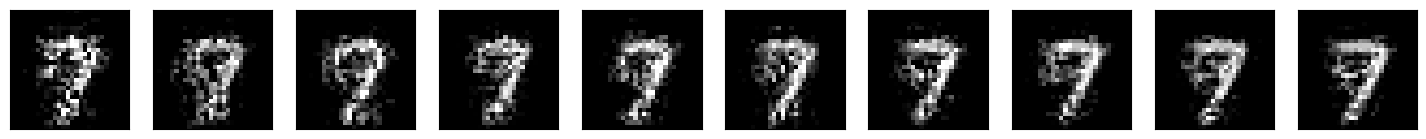

In [37]:
iter_cf = 0
print(f'iteration c {iter_cf}')
n = len(explanation['all'][iter_cf])
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n+1, i+1)
    plt.imshow(explanation['all'][iter_cf][i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Por lo general, las primeras iteraciones ya dirigen el 7 hacia un 9, mientras que las iteraciones posteriores hacen que el contrafactual sea más escaso.

### Prototipos definidos por las k-instancias codificadas más cercanas

En el ejemplo anterior, los prototipos de clase se definen mediante la codificación promedio de todas las instancias que pertenecen a la clase específica. Sin embargo, otra estrategia viable es **seleccionar únicamente las instancias codificadas más cercanas de una clase a la instancia codificada** que se va a explicar, y luego usar el promedio sobre esas codificaciones como prototipo.


Volvemos a proceder a inicializar un objeto de ***CounterfactualProto*** al que se le pasan como parámetros el `modelo de clasificación cnn`, la forma de los datos `shape`, así como otros parámetros como `gamma`, `theta`, `ae_model`, `enc_model`, `max_iterations`, `feature_range`, `c_init` y `c_steps`. Pero en este caso vamos a obtener 2 explicaciones particulares:

-Utilizando el promedio de las codificaciones de **la clase más cercana**.

-Utilizando el promedio de las codificaciones de **las 20 clase más cercanas**.

In [38]:
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
explanation_k1 = cf.explain(X, k=1, k_type='mean')
explanation_k20 = cf.explain(X, k=20, k_type='mean')

Observamos los resultados para
k=1, el caso del promedio de las codificaciones de **la clase más cercana**:

Counterfactual prediction: 9
Closest prototype class: 9


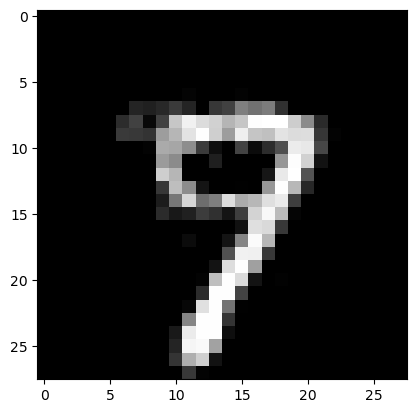

In [39]:
print('Counterfactual prediction: {}'.format(explanation_k1.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k1.cf['X'].reshape(28, 28), cmap='gray');

Observamos los resultados para
k=20, el caso del promedio de las codificaciones de **las 20 clases más cercanas**:

Counterfactual prediction: 9
Closest prototype class: 9


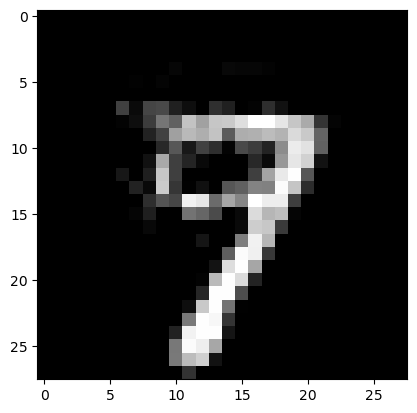

In [40]:
print('Counterfactual prediction: {}'.format(explanation_k20.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k20.cf['X'].reshape(28, 28), cmap='gray');

Un valor menor de k suele conducir a contrafactuales que se parecen más al caso original y menos a un caso promedio de la clase contrafáctica.

### Eliminar el término de pérdida del codificador automático $L_{AE}$

En el ejemplo anterior, utilizamos un término de pérdida del codificador automático para penalizar un contrafactual que queda fuera de la distribución de datos de entrenamiento, así como un término de pérdida del codificador para guiar el contrafactual a la clase de prototipo más cercana. En el siguiente ejemplo, nos deshacemos del término de pérdida del codificador automático para acelerar la búsqueda contrafactual y seguir generando contrafactuales decentes:

In [41]:
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X, k=1)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 3.217 sec


Resultados:

Counterfactual prediction: 9
Closest prototype class: 9


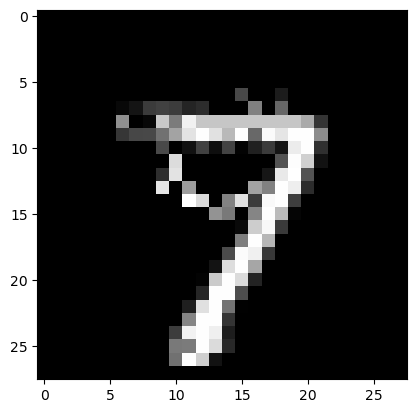

In [42]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28), cmap='gray');

### Especificar clases de prototipo


Para predicciones de clases múltiples, podría interesarnos generar contrafácticos para ciertas clases y evitar otras. El siguiente ejemplo ilustra cómo hacer esto:

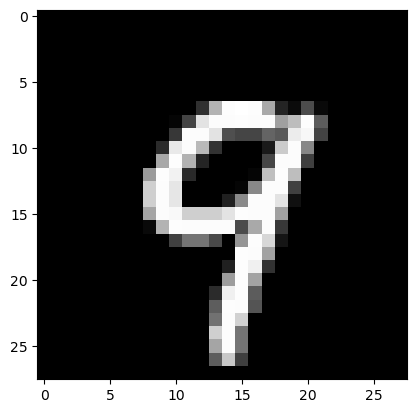

In [43]:
X = x_test[12].reshape((1,) + x_test[1].shape)
plt.imshow(X.reshape(28, 28), cmap='gray');

In [44]:
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
explanation_1 = cf.explain(X, k=5, k_type='mean')
proto_1 = explanation_1.id_proto
explanation_2 = cf.explain(X, k=5, k_type='mean', target_class=[7])
proto_2 = explanation_2.id_proto

La clase más cercana al 9 es 4. Esto es evidente al observar el primer contrafactual a continuación. Para el segundo contrafactual, especificamos que la clase prototipo utilizada en la búsqueda debería ser un 7(se fuerza). Como resultado, se genera un contrafactual 7 en lugar de un 4.

Counterfactual prediction: 4
Closest prototype class: 4


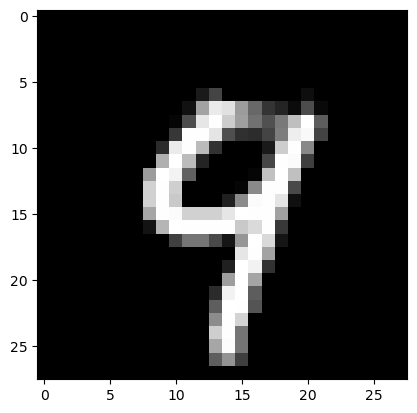

In [45]:
print('Counterfactual prediction: {}'.format(explanation_1.cf['class']))
print(f'Closest prototype class: {proto_1}')
plt.imshow(explanation_1.cf['X'].reshape(28, 28), cmap='gray');

Counterfactual prediction: 7
Closest prototype class: 7


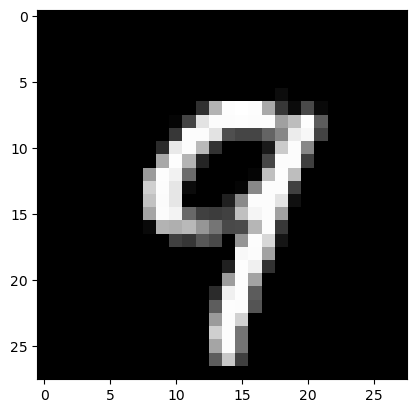

In [46]:
print('Counterfactual prediction: {}'.format(explanation_2.cf['class']))
print(f'Closest prototype class: {proto_2}')
plt.imshow(explanation_2.cf['X'].reshape(28, 28), cmap='gray');

### Acelerar la búsqueda contrafactual eliminando el término de pérdida de la función de predicción


También podemos eliminar el término de pérdida de predicción y aún así obtener un contrafactual interpretable. Esto es especialmente relevante para los modelos de caja totalmente negra. Cuando proporcionamos al método de búsqueda contrafactual un modelo Keras o TensorFlow, se incorpora al gráfico de TensorFlow y se evalúa mediante diferenciación automática. Sin embargo, si solo tenemos acceso a la función de predicción del modelo, las actualizaciones de gradiente son numéricas y normalmente requieren una gran cantidad de llamadas de predicción debido al término de pérdida de predicción.

Estas llamadas de predicción pueden ralentizar significativamente la búsqueda y convertirse en un cuello de botella. Podemos representar el gradiente del término de pérdida de la siguiente manera:

$$
\frac{\partial L_{pred}}{\partial x} = \frac{\partial L_{pred}}{\partial p} \cdot \frac{\partial p}{\partial x}
$$


dónde $L_{pred}$
es el término de pérdida de predicción,
la función de predicción y x
las características de entrada para optimizar. Para una imagen MNIST de 28 por 28, el $\frac{\partial p}{\partial x}$.


El término por sí solo requeriría una llamada de predicción con un tamaño de lote de 28x28x2 = 1568. Sin embargo, al usar los prototipos para guiar la búsqueda, podemos eliminar el término de pérdida de predicción y solo hacer una única predicción al final de cada actualización de gradiente para verificar si la clase predicha en el contrafactual propuesto es diferente de la clase original. Tampoco necesitamos necesariamente un codificador automático Keras o TensorFlow y podemos usar árboles kd para encontrar los prototipos de clase más cercanos.



El primer ejemplo siguiente elimina $L_{pred}$
de la función de pérdida para evitar el cuello de botella. Ilustra las drásticas mejoras de velocidad con respecto a la alternativa de caja negra con evaluación de gradiente numérico y al mismo tiempo produce casos contrafactuales interpretables.

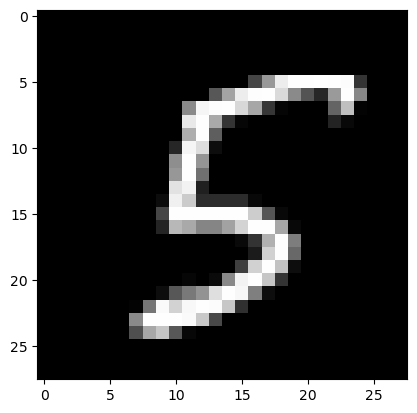

In [47]:
plt.gray()
X = x_test[23].reshape(1, 28, 28, 1)
plt.imshow(X.reshape(28, 28));

In [48]:
c_init = 0.  # weight on prediction loss term set to 0
c_steps = 1  # no need to find optimal values for c

In [49]:
# define a black-box model
predict_fn = lambda x: cnn.predict(x)

# initialize explainer, fit and generate counterfactuals
cf = CounterfactualProto(predict_fn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X, k=1)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 3.145 sec


Counterfactual prediction: 6
Closest prototype class: 6


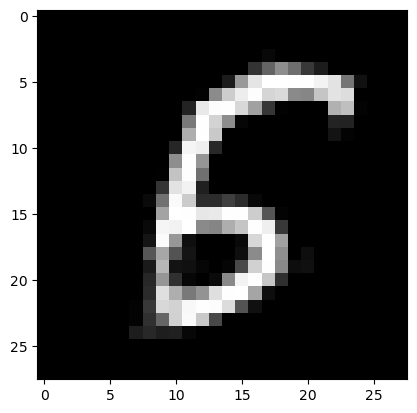

In [50]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

Háganos saber agregar el $L_{pred}$
término de pérdida nuevamente en la función objetivo y observe cuánto tiempo lleva generar un contrafactual de caja negra:

In [51]:
c_init = 1.
c_steps = 2

In [52]:
# define a black-box model
predict_fn = lambda x: cnn.predict(x)

cf = CounterfactualProto(predict_fn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X, k=1)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 597.014 sec


Counterfactual prediction: 6
Closest prototype class: 6


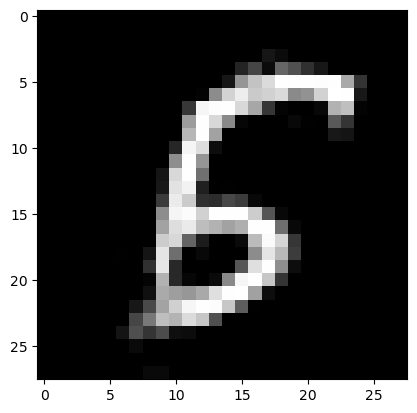

In [53]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

## Pruebas propias sobre el mismo dataset

Consideraremos otro dígito para el análisis. Concretamente hemos elegido un dígito que representa el número 4, por lo que su etiqueta será '4'. No ostante, tal y como vamos a observar, este dígito puede llegar a plantear confusión con otros de los dígitos de clasificación.

Procedemos a la elección y visualización del dígito original elegido dentro del conjunto de prueba.

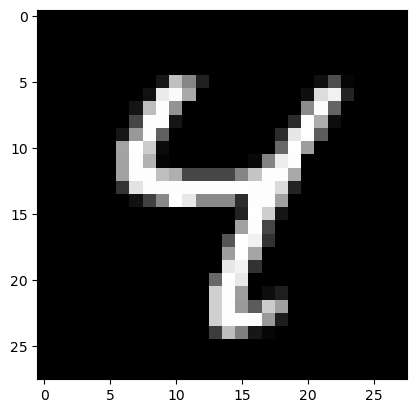

In [54]:
X_p = x_test[6].reshape((1,) + x_test[7].shape)
plt.imshow(X_p.reshape(28, 28));

Vamos a adentrarnos un poco más en las descripciones de las diferentes variables que hemos observado anteriormente:

$\gamma$ (`gamma`): controla la importancia de la penalización en la **distancia** entre el contrafactual y la instancia original. Un valor más alto puede hacer que el algoritmo priorice la minimización de la distancia, lo que podría resultar en contrafactuales que se parecen más a la instancia original. Por otro lado, un valor más bajo puede permitir que el algoritmo se desvíe más de la instancia original en busca de un contrafactual que satisfaga las restricciones de un problema particular.


$\theta$ (`theta`): controla la importancia de la penalización en la **desviación de las características** del contrafactual respecto a las características del prototipo de clase. Un valor más alto puede hacer que el algoritmo priorice la cercanía del contrafactual al prototipo de clase, lo que podría resultar en contrafactuales que se parecen más al promedio de la clase. Por otro lado, un valor más bajo puede permitir que el algoritmo se desvíe más de las características de la clase en busca de un contrafactual que satisfaga las restricciones del problema.


Punto de partida inicial (`c_init`): inicio para la búsqueda del contrafactual. Un valor más bajo, como 1, podría iniciar la búsqueda más cerca de la instancia original, lo que podría resultar en contrafactuales que se parecen más a la instancia original. Por otro lado, un valor más alto podría iniciar la búsqueda más lejos de la instancia original, lo que podría permitir contrafactuales que se desvíen más de la instancia original.


Cantidad de pasos (`c_steps)`: pasos o iteraciones en la búsqueda del contrafactual. Un valor más alto, como 3, podría permitir un mayor número de pasos en la búsqueda, lo que podría permitir una exploración más exhaustiva del espacio de características en busca de un contrafactual satisfactorio. Por otro lado, un valor más bajo podría limitar la cantidad de pasos en la búsqueda, lo que podría resultar en una exploración menos exhaustiva del espacio de características.



Consideraremos una variación considerable de los parámetros `gamma` y `theta`(concretamente de 100 a 10).

Buscaremos las explicaciones contrafactuales de la siguiente forma:

-Utilizando k=1 y el promedio de las codificaciones de **la clase más cercana**.

-Utilizando k=20 y el promedio de las codificaciones de **las 20 clase más cercanas**.

In [55]:
gamma=10
theta=10

cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
explanation_k1 = cf.explain(X, k=1, k_type='mean')
explanation_k20 = cf.explain(X, k=20, k_type='mean')

No counterfactual found!
No counterfactual found!


Considerando `gamma`=10 y `theta`=10, no conseguimos ningún contrafactual, parece ser que el algoritmo se desvincula de cualquier posible contrafactual.

Redefinimos unas variables concretas que sean compatibles con la búsqueda obtenida y realizamos el mismo proceso:

In [56]:
shape = (1,) + x_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 2.
c_steps = 3
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())

In [57]:
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
explanation_k1 = cf.explain(X_p, k=1, k_type='mean')
explanation_k20 = cf.explain(X_p, k=20, k_type='mean')

Counterfactual prediction: 9
Closest prototype class: 6


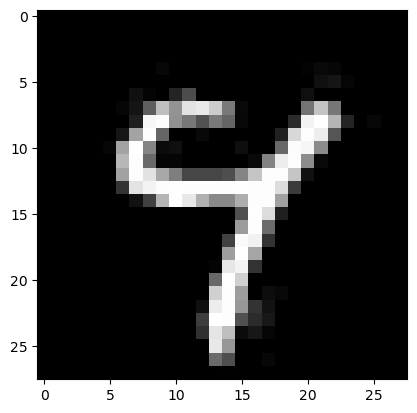

In [58]:
print('Counterfactual prediction: {}'.format(explanation_k1.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k1.cf['X'].reshape(28, 28));



Obtenemos que la predicción contrafactual de 9 y el prototipo de clase más cercano de 6 sugieren que el modelo ha respondido de manera coherente a los cambios introducidos en el dígito original. Lo que indica que, después de la transformación, el dígito se asemeja más a un 9 en términos de cómo el modelo lo interpreta y clasifica.

La proximidad del prototipo de clase más cercano a 6 puede indicar cómo las transformaciones aplicadas al dígito original lo han movido en el espacio de características, acercándolo a la región donde se encuentran los ejemplos representativos de la clase 6. Esto destaca la complejidad y la riqueza del espacio de características y cómo los cambios en los datos de entrada pueden afectar a las predicciones del modelo.

Counterfactual prediction: 9
Closest prototype class: 6


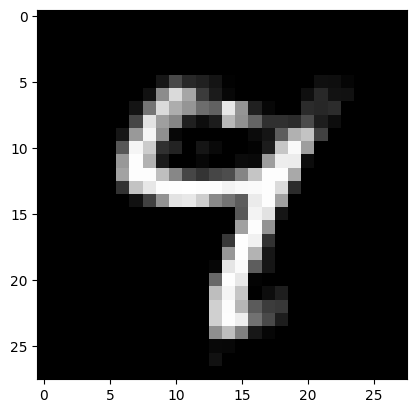

In [ ]:
print('Counterfactual prediction: {}'.format(explanation_k20.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k20.cf['X'].reshape(28, 28));

Obtenemos los mismos resultados que anteriormente pero, en este caso, observamos que en la representación gráfica se puede distingir de manera simple que el nuevo dígito es mucho más semejante al 9 que al originalmente 4.

A continuación, vamos a proceder a especificar las clases prototipo, considerando todas aquellas posibles dado nuestro rango de características.

Concretamente, especificaremos todas las clases posibles menos la original(0, 1, 2, 3, 5, 6, 7, 8 y 9) usando el método de los 10-vecinos más cercanos usandonla media de los atributos de estos.

In [59]:
# Clase objetivo 0
explanation_0 = cf.explain(X_p, k=10, k_type='mean', target_class=[0])
proto_0 = explanation_0.id_proto

# Clase objetivo 1
explanation_1 = cf.explain(X_p, k=10, k_type='mean', target_class=[1])
proto_1 = explanation_1.id_proto

# Clase objetivo 2
explanation_2 = cf.explain(X_p, k=10, k_type='mean', target_class=[2])
proto_2 = explanation_2.id_proto

# Clase objetivo 3
explanation_3 = cf.explain(X_p, k=10, k_type='mean', target_class=[3])
proto_3 = explanation_3.id_proto

#explanation_4 = cf.explain(X_p, k=10, k_type='mean', target_class=[4])
#proto_4 = explanation_4.id_proto

# Clase objetivo 5
explanation_5 = cf.explain(X_p, k=10, k_type='mean', target_class=[5])
proto_5 = explanation_5.id_proto

# Clase objetivo 6
explanation_6 = cf.explain(X_p, k=10, k_type='mean', target_class=[6])
proto_6 = explanation_6.id_proto

# Clase objetivo 7
explanation_7 = cf.explain(X_p, k=10, k_type='mean', target_class=[7])
proto_7 = explanation_7.id_proto

# Clase objetivo 8
explanation_8 = cf.explain(X_p, k=10, k_type='mean', target_class=[8])
proto_8 = explanation_8.id_proto

# Clase objetivo 9
explanation_9 = cf.explain(X_p, k=10, k_type='mean', target_class=[9])
proto_9 = explanation_9.id_proto

# SIN clases objetivo previas, la selecciona automaticamente
explanation_best = cf.explain(X_p, k=10, k_type='mean')
proto_best = explanation_best.id_proto

Counterfactual prediction: 0
Closest prototype class: 0


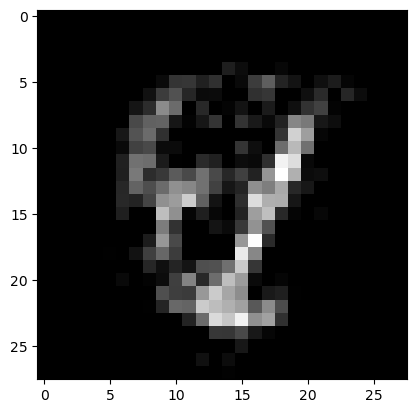

In [60]:
print('Counterfactual prediction: {}'.format(explanation_0.cf['class']))
print(f'Closest prototype class: {proto_0}')
plt.imshow(explanation_0.cf['X'].reshape(28, 28));

Observamos que nuestro dígito se ha deformado totalmente.

Counterfactual prediction: 1
Closest prototype class: 1


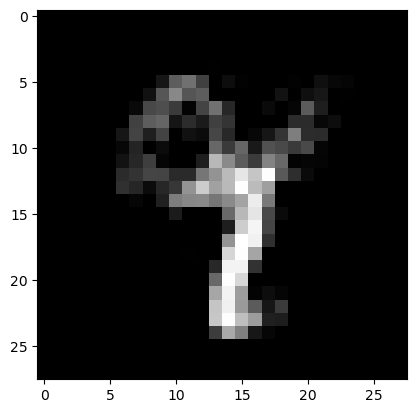

In [61]:
print('Counterfactual prediction: {}'.format(explanation_1.cf['class']))
print(f'Closest prototype class: {proto_1}')
plt.imshow(explanation_1.cf['X'].reshape(28, 28));

Observamos que nuestro dígito no se ha deformado, sinó que se han concentrado más datos apelmazados formando la figura de algo aproximado a un 1.

Counterfactual prediction: 2
Closest prototype class: 2


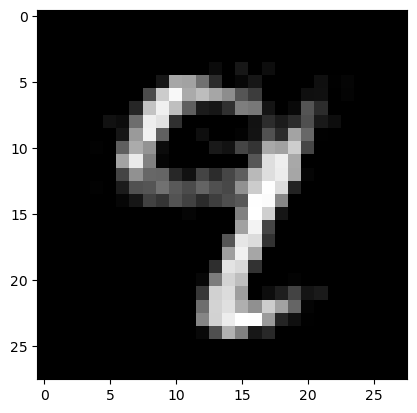

In [62]:
print('Counterfactual prediction: {}'.format(explanation_2.cf['class']))
print(f'Closest prototype class: {proto_2}')
plt.imshow(explanation_2.cf['X'].reshape(28, 28));

Observamos que nuestro dígito no se ha deformado, sinó que se han concentrado más datos apelmazados formando la figura de algo aproximado a un 2 tal como pasaba en el anterior caso.

Counterfactual prediction: 3
Closest prototype class: 3


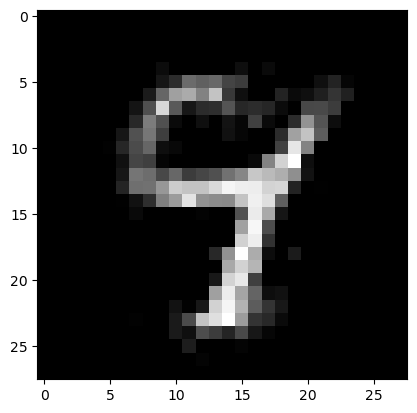

In [63]:
print('Counterfactual prediction: {}'.format(explanation_3.cf['class']))
print(f'Closest prototype class: {proto_3}')
plt.imshow(explanation_3.cf['X'].reshape(28, 28));

Observamos que nuestro dígito no se ha deformado prácticamente nada.

Counterfactual prediction: 5
Closest prototype class: 5


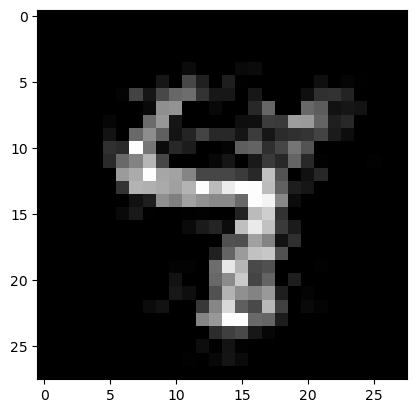

In [65]:
print('Counterfactual prediction: {}'.format(explanation_5.cf['class']))
print(f'Closest prototype class: {proto_5}')
plt.imshow(explanation_5.cf['X'].reshape(28, 28));

Observamos que nuestro dígito se ha deformado bastante.

Counterfactual prediction: 6
Closest prototype class: 6


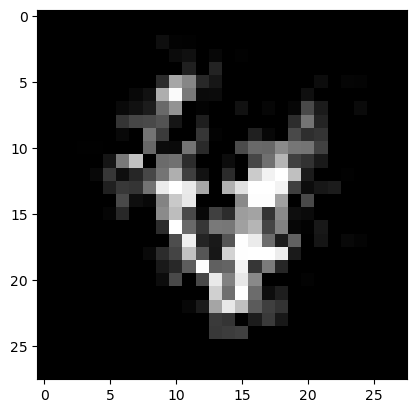

In [66]:
print('Counterfactual prediction: {}'.format(explanation_6.cf['class']))
print(f'Closest prototype class: {proto_6}')
plt.imshow(explanation_6.cf['X'].reshape(28, 28));

Observamos que nuestro dígito se ha deformado totalmente.

Counterfactual prediction: 7
Closest prototype class: 7


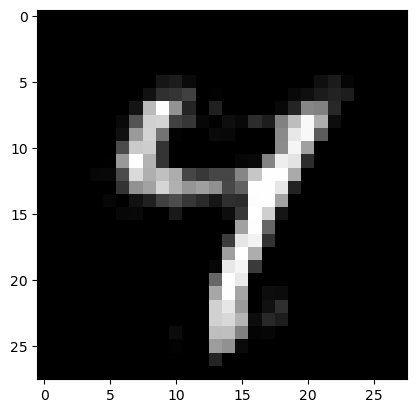

In [67]:
print('Counterfactual prediction: {}'.format(explanation_7.cf['class']))
print(f'Closest prototype class: {proto_7}')
plt.imshow(explanation_7.cf['X'].reshape(28, 28));

Observamos que nuestro dígito no se ha deformado prácticamente.

Counterfactual prediction: 8
Closest prototype class: 8


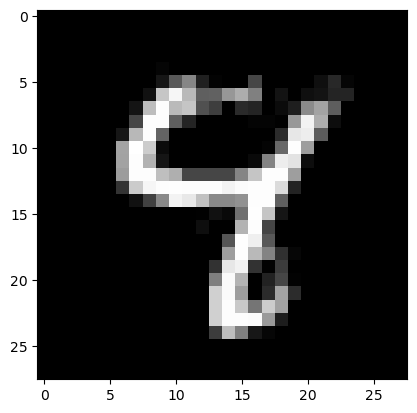

In [68]:
print('Counterfactual prediction: {}'.format(explanation_8.cf['class']))
print(f'Closest prototype class: {proto_8}')
plt.imshow(explanation_8.cf['X'].reshape(28, 28));

A partir del dígito inicial, sorprendentemente, ha construido un 8 bastante evidente.

Counterfactual prediction: 9
Closest prototype class: 9


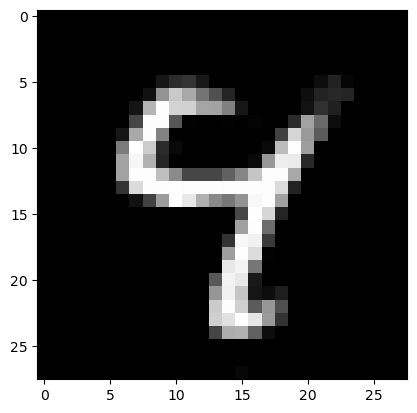

In [70]:
print('Counterfactual prediction: {}'.format(explanation_9.cf['class']))
print(f'Closest prototype class: {proto_9}')
plt.imshow(explanation_9.cf['X'].reshape(28, 28));

Counterfactual prediction: 9
Closest prototype class: 9


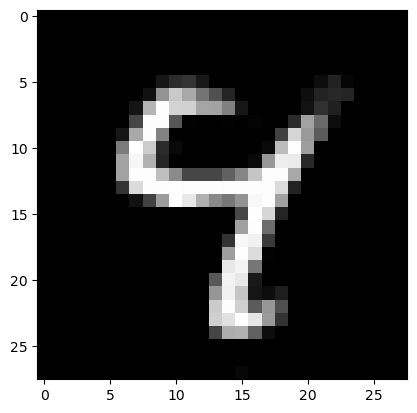

In [71]:
print('Counterfactual prediction: {}'.format(explanation_best.cf['class']))
print(f'Closest prototype class: {proto_best}')
plt.imshow(explanation_best.cf['X'].reshape(28, 28));

Las últimas dos representaciones de los resultados de las respectivas explicaciones contrafactualesson la misma ya que se trata del dígito 9 tal y como hemos comentado anteriormente.


In [ ]:
os.remove('mnist_cnn.h5')
os.remove('mnist_ae.h5')
os.remove('mnist_enc.h5')

Todo el código de ejemplo ha sido sacado de la librería `alibi`, nosotros hemos incorporado explicaciones detalladas y algunas pruebas extras para la ayuda de la comprensión del método particular con el que estamos trabajando.

Para obtener más códigos de ejemplo, navegar en la libreria.